# Deep Q-Network (DQN) for LunarLander-v2

This notebook is an implementation of a Deep Q-Network to tackle the "LunarLander-v2" environment in OpenAI Gym. The DQN will learn to land a spacecraft safely on the lunar surface. The goal is to achieve an average score of 195 or above over the last 50 episodes.

### Import Libraries

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import os
import renderlab
import itertools

### Define the Hyperparameters

Setting up hyperparameters like learning rate, batch size, exploration rates, and defining the file path for saving the trained DQN model.

In [2]:
# Define the Parameters
GAMMA = 0.99
BATCH_SIZE = 128
BUFFER_SIZE = 10000
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995
LEARNING_RATE = 0.0005
solved_score = 195 
model_save_path = 'dqn_lunarlander_model.pth'

### Standard DQN Model

Below is the neural network that will approximate the Q-value function. The network will take the state as input and output Q-values for each action.

In [3]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Replay Memory

Using a replay memory to store transitions that the agent observes, allowing to reuse this data later. This helps in breaking the correlation between consecutive learning samples.

In [4]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### DQN Agent Class

Encapsulating the learning mechanisms of the DQN agent, including action selection, model optimization, and interaction with the replay memory, along with managing the exploration rate decay.

In [5]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = EPS_START

        self.policy_net = DQN(state_size, action_size)
        self.target_net = DQN(state_size, action_size)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)
        self.memory = ReplayMemory(BUFFER_SIZE)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.epsilon
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return

        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, dtype=torch.float32)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        next_state_values = torch.zeros(BATCH_SIZE)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * GAMMA) * (1 - done_batch) + reward_batch

        loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(EPS_END, EPS_DECAY * self.epsilon)

### Training Loop

Runs the LunarLander-v2 environment for a set number of episodes, gathering experiences and optimizing the agent's policy network based on these experiences.

In [6]:
env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

scores = []
average_scores = []
max_steps_per_episode = 2000  # Maximum steps per episode to prevent very long episodes
solved_score = 195  # Solved condition threshold
solved = False  # Flag to indicate whether the environment is solved

# Wrap the episode range with tqdm for the progress bar
for i_episode in itertools.count():
    state_tuple = env.reset()
    state = state_tuple[0] if isinstance(state_tuple, tuple) else state_tuple
    state = torch.from_numpy(state).float().unsqueeze(0)
    total_reward = 0
    done = False
    step_count = 0  # Step counter for each episode

    while not done and step_count < max_steps_per_episode:
        action = agent.select_action(state)
        output = env.step(action.item())
        next_state = output[0]
        reward = output[1]
        done = output[2]

        next_state = torch.from_numpy(next_state).float().unsqueeze(0)
        reward_tensor = torch.tensor([reward], dtype=torch.float)

        agent.memory.push(state, action, next_state, reward_tensor, done)
        state = next_state
        total_reward += reward
        agent.optimize_model()

        step_count += 1

    agent.update_target_net()
    agent.decay_epsilon()
    scores.append(total_reward)

    # Calculate average score of the last 50 episodes
    if len(scores) >= 50:
        avg_score_last_50 = np.mean(scores[-50:])
        average_scores.append(avg_score_last_50)

        # Check if the environment is solved
        if avg_score_last_50 >= solved_score and not solved:
            print("*"*125)
            print(f"Solved at episode: {i_episode} - Average score over the last 50 episodes: {avg_score_last_50}")
            torch.save(agent.policy_net.state_dict(), model_save_path)
            print(f"Model successfully saved to {model_save_path}")
            solved = True
            break  # Stop training since the environment is considered solved

    ## Output progress every 10 episodes
    #if i_episode % 10 == 0:
    #    # Calculate the average of the last 10 episodes
    #    avg_score_last_10 = np.mean(scores[-10:])
    #    print(f"Episode {i_episode}, Average Score Last 10 Episodes: {avg_score_last_10}")
    
    
    # Output progress for every episode
    print(f"Episode {i_episode}, Score: {total_reward}")
    
env.close()

Episode 0, Score: -164.72357118603384
Episode 1, Score: -80.88794510693423
Episode 2, Score: -160.84909506184005
Episode 3, Score: -199.60365583622905
Episode 4, Score: -309.77531792989987
Episode 5, Score: -121.6003159491332
Episode 6, Score: -168.3979629159067
Episode 7, Score: -428.648492036548
Episode 8, Score: -434.2724454060592
Episode 9, Score: -117.08001942493158
Episode 10, Score: -106.5712898575979
Episode 11, Score: -186.2671810160717
Episode 12, Score: -360.36394451842057
Episode 13, Score: -7.32515403712182
Episode 14, Score: -125.70161451302069
Episode 15, Score: -120.03625790404871
Episode 16, Score: -320.8934922907132
Episode 17, Score: -71.90376006620994
Episode 18, Score: -230.06359338353997
Episode 19, Score: -106.81110831305578
Episode 20, Score: -160.15479448463216
Episode 21, Score: -91.4015222625518
Episode 22, Score: -155.6862391932176
Episode 23, Score: -217.81414376466745
Episode 24, Score: -241.05550658694796
Episode 25, Score: -101.19899809706524
Episode 26,

Episode 213, Score: -37.64928800994741
Episode 214, Score: -239.31626343979437
Episode 215, Score: -73.36560223540013
Episode 216, Score: 33.59878381394617
Episode 217, Score: -37.78438871836953
Episode 218, Score: -23.686822150330755
Episode 219, Score: -47.367392292067706
Episode 220, Score: -148.3030339441918
Episode 221, Score: 8.195756437853689
Episode 222, Score: 17.37612962314313
Episode 223, Score: 65.91767407519605
Episode 224, Score: -70.5738216894018
Episode 225, Score: -8.792696962958672
Episode 226, Score: -2.5673428693961515
Episode 227, Score: -6.570411015407387
Episode 228, Score: 19.73844450321556
Episode 229, Score: 29.46220026387002
Episode 230, Score: -20.131360272441356
Episode 231, Score: 45.42139013729147
Episode 232, Score: 17.626299126760642
Episode 233, Score: 93.74817024323661
Episode 234, Score: -36.73099376424828
Episode 235, Score: -94.34721954627076
Episode 236, Score: -4.123988087339114
Episode 237, Score: 36.499781273568715
Episode 238, Score: 69.914506

Episode 425, Score: 210.53348631160952
Episode 426, Score: 121.47482617816448
Episode 427, Score: 299.05882340296296
Episode 428, Score: -31.687486075030833
Episode 429, Score: 282.1521379741875
Episode 430, Score: 253.89425790685087
Episode 431, Score: 221.07621160644393
Episode 432, Score: 175.82265015474928
Episode 433, Score: 288.8119230964336
Episode 434, Score: 229.04264599612537
Episode 435, Score: 246.56710658832142
Episode 436, Score: 261.09527079923646
Episode 437, Score: 264.9157893443686
Episode 438, Score: 262.29320786873774
Episode 439, Score: 229.60839681774664
Episode 440, Score: 218.97041150014797
Episode 441, Score: 197.29485090550412
Episode 442, Score: 175.15642805407805
Episode 443, Score: 160.34366318928596
Episode 444, Score: 216.9418557321886
Episode 445, Score: 203.4064293964314
Episode 446, Score: 256.6843790337223
Episode 447, Score: 189.9594626789342
Episode 448, Score: 190.69053924564543
Episode 449, Score: 216.81051772755222
*******************************

### Training Progress Visualization

Visualizing the training progress with a plot of the average reward per episode (Y-axis) against the number of episodes (X-axis).

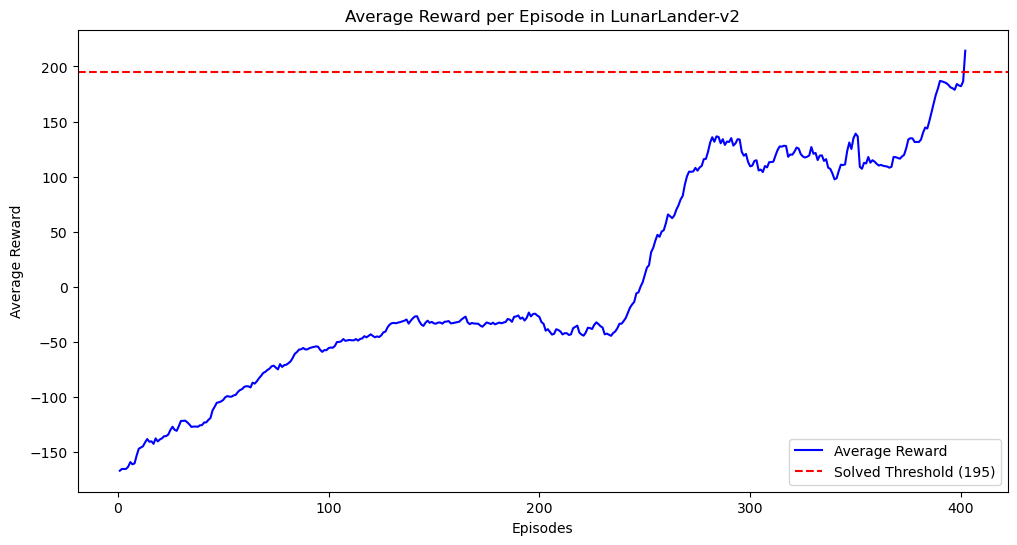

In [7]:
# Creating the plot
episode_numbers = list(range(1, len(average_scores) + 1))

plt.figure(figsize=(12, 6))
plt.plot(episode_numbers, average_scores, label='Average Reward', color='blue')
plt.axhline(y=solved_score, color='r', linestyle='--', label='Solved Threshold (195)')

# Set x-axis labels to show every 100 episodes
plt.xticks(range(0, len(average_scores) + 1, 100))

plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward per Episode in LunarLander-v2')
plt.legend()
plt.show()

In [8]:
# Initialize the environment
env = gym.make('LunarLander-v2', render_mode='rgb_array')

# Wrap the environment with RenderFrame from renderlab to record video
env = renderlab.RenderFrame(env, "./video")

# Initialize your DQN agent here (make sure it's trained)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
agent.policy_net.load_state_dict(torch.load(model_save_path))

# Reset the environment and get the initial observation
obs, info = env.reset()

while True:
    # Convert the observation to a tensor and pass it to the agent to select an action
    obs_tensor = torch.from_numpy(obs).float().unsqueeze(0)
    action = agent.select_action(obs_tensor).item()

    # Take the action in the environment
    obs, reward, terminated, truncated, info = env.step(action)

    # Check if the episode is done
    if terminated or truncated:
        break

# Play the recorded video
env.play()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4
